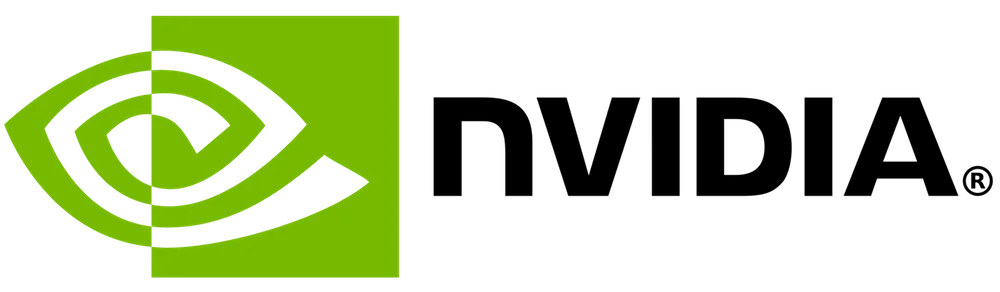

**🔍 Context**

I previously trained a simple model (likely a fully connected neural network) to classify American Sign Language (ASL) images.

The model performed very well on the training set, achieving high accuracy.

However, it did not perform as well on the validation set, meaning it struggled with new, unseen images.

**⚠️ Problem: Overfitting**

The model has memorized the training data instead of learning general patterns that would help it classify new images.

This is known as overfitting, where the model performs well on training data but fails to generalize to new data.

**Proposed Solution: CNN (Convolutional Neural Network)**

*    The text introduces a more suitable type of model for image data: the Convolutional Neural Network (CNN).

*   CNNs are especially good at handling images because:

*   They detect local visual features like edges, textures, and shapes.

*   They use shared filters across the image, which reduces the number of parameters and lowers the risk of overfitting.

*   They can automatically extract relevant features from images for classification.

**🎯 Goal**

The goal is to introduce CNNs as a better alternative to simple models for image classification tasks. It explains that the previous model overfit the training data and that CNNs are designed to generalize better by effectively learning patterns from image data.

In [47]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

**Loading and Preparing the Data**

In [48]:
train_df = pd.read_csv("/content/sign_mnist_train.csv")
valid_df = pd.read_csv("/content/sign_mnist_test.csv")

This ASL data is already flattened.

In [49]:
sample_df = train_df.head().copy()  # Grab the top 5 rows
sample_df.pop('label')
sample_x = sample_df.values
sample_x

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       [211, 211, 212, ..., 222, 229, 163],
       [164, 167, 170, ..., 163, 164, 179]])

In [50]:
sample_x.shape

(5, 784)



In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of color channels. Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape (5, 784) to (5, 1, 28, 28). With NumPy arrays, we can pass a -1 for any dimension we wish to remain the same.



In [51]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1

sample_x = sample_x.reshape(-1, IMG_CHS, IMG_HEIGHT, IMG_WIDTH)
sample_x.shape

(5, 1, 28, 28)

**Exercise**

There are 4 `FIXMEs` in the class definition below. Can you replace them with the correct values?

In [52]:
# SOLUTION
class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()  # Some operations below are in-place
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df.values).long().to(device)



    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

**Create a DataLoader**

**Exercise**



One of these function calls is missing the shuffle=True argument. Can you remember which one it is and add it back in?


In [53]:
BATCH_SIZE = 32

train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)


In [54]:
# SOLUTION
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)




Let's grab a batch from the DataLoader to make sure it works.


In [55]:


batch = next(iter(train_loader))
batch



[tensor([[[[0.4431, 0.4588, 0.4667,  ..., 0.4627, 0.4549, 0.4471],
           [0.4471, 0.4588, 0.4706,  ..., 0.4706, 0.4627, 0.4549],
           [0.4510, 0.4588, 0.4745,  ..., 0.4784, 0.4706, 0.4627],
           ...,
           [0.4627, 0.4627, 0.4745,  ..., 0.5882, 0.5922, 0.5765],
           [0.2980, 0.2980, 0.2941,  ..., 0.5608, 0.5098, 0.4784],
           [0.3255, 0.3333, 0.3333,  ..., 0.4824, 0.4980, 0.4784]]],
 
 
         [[[0.6667, 0.6863, 0.6902,  ..., 0.6588, 0.6549, 0.6471],
           [0.6745, 0.6902, 0.6941,  ..., 0.6627, 0.6588, 0.6510],
           [0.6824, 0.6941, 0.6980,  ..., 0.6745, 0.6627, 0.6549],
           ...,
           [0.7686, 0.7765, 0.7922,  ..., 0.8118, 0.8039, 0.7961],
           [0.7686, 0.7804, 0.7961,  ..., 0.8157, 0.8078, 0.7961],
           [0.7725, 0.7804, 0.7922,  ..., 0.8118, 0.8039, 0.7922]]],
 
 
         [[[0.5333, 0.5529, 0.5608,  ..., 0.6588, 0.6549, 0.6549],
           [0.5333, 0.5529, 0.5647,  ..., 0.6667, 0.6627, 0.6588],
           [0.5412

In [56]:
batch[0].shape

torch.Size([32, 1, 28, 28])

In [57]:
batch[1].shape

torch.Size([32])

**Creating a Convolutional Model**

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.


We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [Stack Overflow](https://stackoverflow.com/)).

In [58]:
n_classes = 25
kernel_size = 3
flattened_img_size = 75 * 3 * 3

model = nn.Sequential(
    # First convolution
    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3
    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, n_classes)
)

**Conv2D**


These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1)
```
25 refers to the number of filters that will be learned. Even though `kernel_size = 3`, PyTorch will assume we want 3 x 3 filters. Stride refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

**[BatchNormalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)**

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

There is a debate on best where to put the batch normalization layer. [This Stack Overflow post](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) compiles many perspectives.

[MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

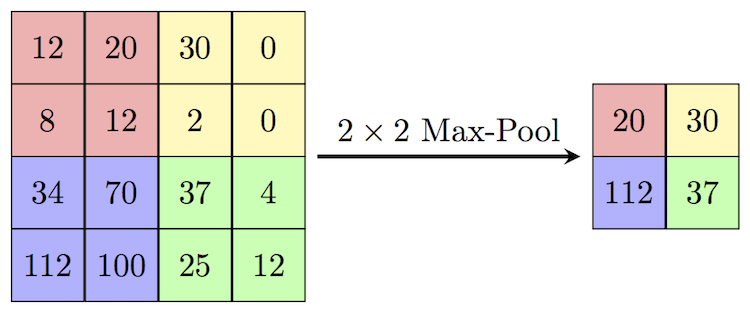

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.


[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

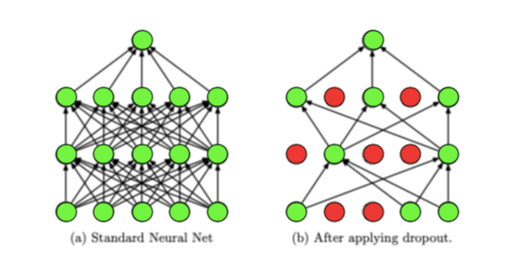

 Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.


**Flatten**

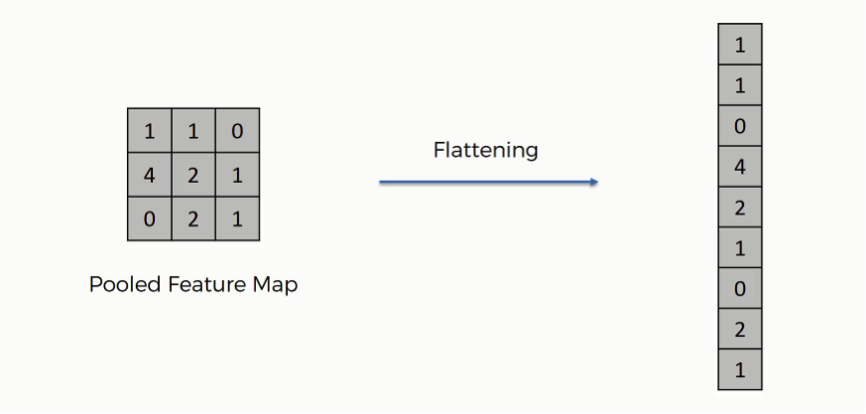

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

We have seen dense linear layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

**Summarizing the model**

In [59]:
model = torch.compile(model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=675, out_features=512, bias=True)
    (15): Dropout

In [60]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [61]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

**TRaining the Model**

Despite the very different model architecture, the training looks exactly the same.

**Exercise**

These are the same `train` and `validate` functions as before, but they have been mixed up. Can you correctly name each function and replace the `FIXME`s?

One of them should have `model.train` and the other should have `model.eval`.

In [62]:
def FIXME():
    loss = 0
    accuracy = 0

    model.FIXME()
    with torch.no_grad():
        for x, y in FIXME:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('FIXME - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [63]:
def FIXME():
    loss = 0
    accuracy = 0

    model.FIXME()
    for x, y in FIXME:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('FIXME - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

**Solution**

In [64]:
# SOLUTION
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [65]:
# SOLUTION
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [66]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [67]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 265.8182 Accuracy: 0.9085
Valid - Loss: 29.8748 Accuracy: 0.9622
Epoch: 1
Train - Loss: 18.8704 Accuracy: 0.9938
Valid - Loss: 20.9318 Accuracy: 0.9704
Epoch: 2
Train - Loss: 4.5943 Accuracy: 0.9987
Valid - Loss: 25.2932 Accuracy: 0.9643
Epoch: 3
Train - Loss: 16.9412 Accuracy: 0.9942
Valid - Loss: 18.4132 Accuracy: 0.9703
Epoch: 4
Train - Loss: 3.4800 Accuracy: 0.9991
Valid - Loss: 14.1702 Accuracy: 0.9856
Epoch: 5
Train - Loss: 4.4735 Accuracy: 0.9988
Valid - Loss: 365.7017 Accuracy: 0.6484
Epoch: 6
Train - Loss: 15.1609 Accuracy: 0.9945
Valid - Loss: 19.6539 Accuracy: 0.9724
Epoch: 7
Train - Loss: 4.1080 Accuracy: 0.9989
Valid - Loss: 16.7529 Accuracy: 0.9743
Epoch: 8
Train - Loss: 8.1200 Accuracy: 0.9969
Valid - Loss: 33.2500 Accuracy: 0.9690
Epoch: 9
Train - Loss: 0.1338 Accuracy: 1.0000
Valid - Loss: 26.4663 Accuracy: 0.9762
Epoch: 10
Train - Loss: 2.1490 Accuracy: 0.9993
Valid - Loss: 81.8307 Accuracy: 0.9226
Epoch: 11
Train - Loss: 9.2043 Accuracy: 0.9970

**Discussion of Results**



It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do. Let's talk about it in the next lecture.


**Summary**

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.

**Clear the Memory**

In [69]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}